# 图像反卷积简介

在显微镜成像中，由于光学系统（即显微镜）的特性，图像通常会发生失真。发射光子的生物结构在场景图像中不会100%地反映现实。图像会变得模糊，与光学设置的点扩散函数（PSF）进行卷积。如果我们知道PSF，从技术上讲，可以在某种程度上_撤销_这种卷积。

In [1]:
import numpy as np
from skimage.io import imread, imsave
from skimage.data import cells3d
from skimage.filters import gaussian
from scipy.ndimage import convolve
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
from napari_simpleitk_image_processing import richardson_lucy_deconvolution
import matplotlib.pyplot as plt

为了演示卷积和反卷积，我们暂时假设这张显示细胞核的图像反映了生物样本中的实际情况。

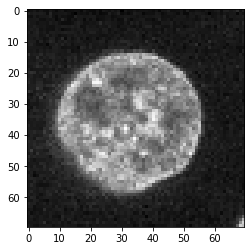

In [2]:
image = cells3d()[30,1,120:190,80:150]
imshow(image)

此外，我们构造一个人工PSF图像。我们从一个完美的PSF图像开始，除了一个像素外，所有像素都是黑色（`0`），通常但不必要在中心。

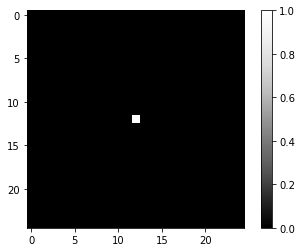

In [3]:
perfect_psf = np.zeros( (25,25) )
perfect_psf[12, 12] = 1

imshow(perfect_psf, colorbar=True)

注意，在上面的例子中，图像的总强度为1。接下来显示的模糊图像的总强度也将接近1。这在后面进行反卷积时至关重要，因为这使得图像（或任何成像的生物结构）的总强度通过反卷积不会改变。

从这个完美的PSF，我们通过高斯模糊得到一个更加实际的PSF示例。

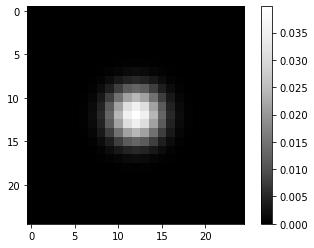

In [4]:
psf = gaussian(perfect_psf, sigma=2)

imshow(psf, colorbar=True)

## 卷积
正如在[图像滤波](image-filtering:convolution)一节中介绍的那样，卷积是将给定输入图像的每个像素值与根据PSF加权的邻近像素结合的过程。

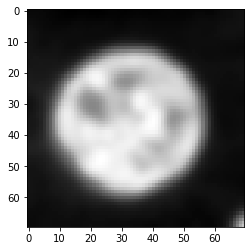

In [5]:
convolved = convolve(image, psf)

imshow(convolved)

## 反卷积
从卷积图像恢复原始图像的一种常见算法是[Richardson-Lucy反卷积](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution)，它在[SimpleITK的RichardsonLucyDeconvolutionImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1RichardsonLucyDeconvolutionImageFilter.html)中有实现。这里我们使用[napari-simpleitk-image-processing]中的一个便捷层。

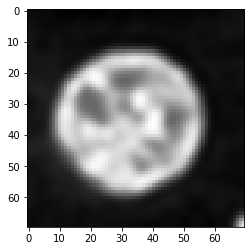

In [6]:
number_of_iterations = 10
deconvolved = richardson_lucy_deconvolution(convolved, psf, number_of_iterations)

imshow(deconvolved)

如你所见，这个反卷积后的图像与上面显示的原始图像不相等。反卷积不是魔法。它是一个图像处理滤波器，所有滤波器都有局限性。此外，对于这个反卷积算法，结果取决于迭代次数。我们可以通过测试不同的值来经验性地找到这个参数的好的数值。

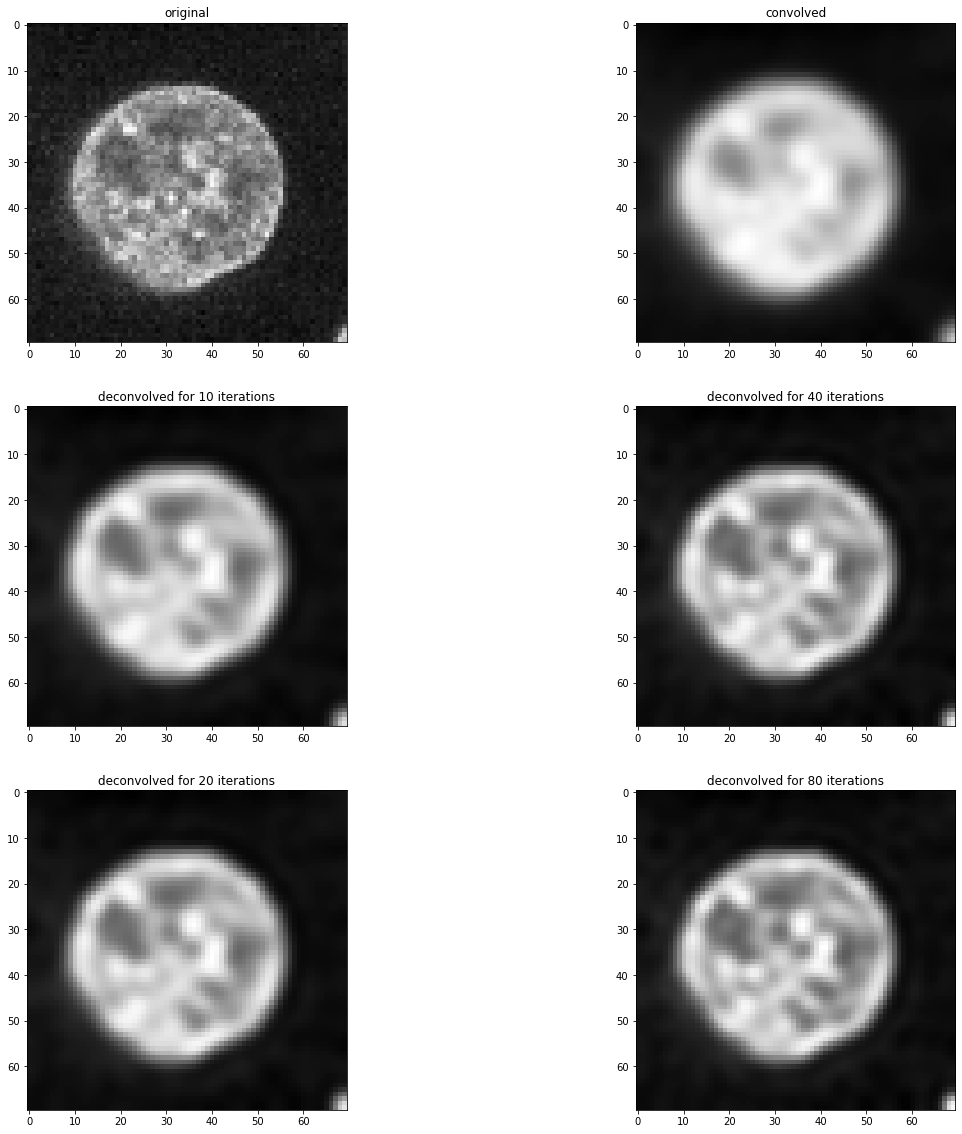

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

imshow(image, plot=axs[0, 0])
axs[0,0].set_title("原始图像")

imshow(convolved, plot=axs[0, 1])
axs[0,1].set_title("卷积后")

for i, number_of_iterations in enumerate([10, 20, 40, 80]):

    deconvolved = richardson_lucy_deconvolution(convolved, psf, number_of_iterations)

    axis = axs[(i) % 2 + 1, int((i) / 2)]
    imshow(deconvolved, plot=axis)
    
    axis.set_title("反卷积 " + str(number_of_iterations) + " 次迭代")

# 练习
编写一个for循环，使用不同的`number_of_iterations`对`convolved`图像进行反卷积，并确定原始图像与反卷积图像之间的[均方误差](https://en.wikipedia.org/wiki/Mean_squared_error)。
提示：你可以使用[sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)。